## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [14]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [15]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
print(livetime)

2.154434690031884


In [16]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.04 s, sys: 132 ms, total: 6.17 s
Wall time: 6.18 s


## Datasets

In [17]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


## Minos

In [18]:
parameter_names = c['parameter_names']
source = 'Crablog'
scan_n_sigma = 2


In [19]:
def computing_surface(dataset, note, idx):
        
    fit_cor = Fit(store_trace=False)
    #result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models[0])
    
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        print( parname1, parname2)
        dataset_asimov.models.parameters[parname1].scan_n_sigma  = scan_n_sigma  
        dataset_asimov.models.parameters[parname2].scan_n_sigma  = scan_n_sigma    
        if dataset_asimov.models.parameters[parname1].scan_min <0:
            dataset_asimov.models.parameters[parname1].scan_min = 1e-15
        if dataset_asimov.models.parameters[parname2].scan_min <0:
            dataset_asimov.models.parameters[parname2].scan_min = 1e-15
        result = fit_cor.stat_surface([dataset],
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                            reoptimize=True)
        print(result)
        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "fit_results":
                contour_write[k] =[float(_) for _ in np.array(result[k]).flatten()]#.tolist()

        with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}_{scan_n_sigma}.yml", "w") as outfile:
        #with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)
        results.append(result)
    return results

def read_in_surface(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}_{scan_n_sigma}.yml", "r") as stream:
        #with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        a = contour[f"{source}.spectral.{parname1}_scan"]
        b = contour[f"{source}.spectral.{parname2}_scan"]
        shape =len(a) , len(b)
        contour['stat_scan'] = np.array(contour['stat_scan']).reshape(shape)
        results.append(contour)
    return results

In [20]:
%%time
computing = 0
if computing:
    results = computing_surface(dataset_asimov, "2.15h", )
else:
    results = read_in_surface("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)

CPU times: user 37 ms, sys: 696 µs, total: 37.7 ms
Wall time: 39.3 ms


In [ ]:
%%time
computing = 1
if computing:
    results_N = computing_surface(dataset_asimov_N, "N_2.15h", 0)
    results_N = computing_surface(dataset_asimov_N, "N_2.15h", 1)
    results_N = computing_surface(dataset_asimov_N, "N_2.15h", 2)
else:
    results_N = read_in_surface("N_2.15h")

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.85e-11   +/- 1.8e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.510   +/-    0.06             
    beta                          :      0.240   +/-    0.06             
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         


amplitude beta


In [10]:
def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def plot_surface(contour, parname1, parname2,
                source = "Crabbreak", note = "", plot_orig = True):
    amplix__ = contour[f"{source}.spectral.{parname1}_scan"]
    indexy__ = contour[f"{source}.spectral.{parname2}_scan"]
    N_new = 110
    N_new_y = 100
    amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
    indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)
    stat_scan = contour["stat_scan"] - np.min(contour["stat_scan"])

    f = interp2d(
        x=indexy__,
        y=amplix__,
        z=stat_scan,
        kind="cubic",
        fill_value=None,
        bounds_error=False,
    )
    data_contour = f(indexy__new, amplix__new)
    
    

    dddd = np.array(contour["stat_scan"])
    ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
    index_best = indexy__[np.where(dddd == dddd.min())[1][0]]
    if plot_orig:
        fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))
        im = ax1.pcolormesh(indexy__, amplix__, stat_scan)
        
        ax1.plot(index_best, ampli_best, "x")
        fig.colorbar(im, ax=ax1)
        ax1.set_ylabel(parname1)
        ax1.set_xlabel(parname2)
        ax1.set_title("Likelihood")
        ax1.plot(dataset_input.models.parameters[parname2].value, 
                dataset_input.models.parameters[parname1].value,
                "+", color = 'white')
    else:
        fig, ax = plt.subplots(1,1)
    im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
    dddd = np.array(data_contour)
    ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
    index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
    print("min index:", index_best)
    print("min amplitude:", ampli_best)

    ax.plot(index_best, ampli_best, "x")
    ax.errorbar(dataset_input.models.parameters[parname2].value, 
            dataset_input.models.parameters[parname1].value,
                xerr = dataset_input.models.parameters[parname2].error, 
                yerr = dataset_input.models.parameters[parname1].error, 
           fmt =  "+", color = 'white')
    
    fig.colorbar(im, ax=ax)
    ax.set_ylabel(parname1)
    ax.set_xlabel(parname2)
    ax.set_title("Likelihood")
    
    threshold_contour = 1

    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best  = compute_errors(
        data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
    )
    threshold = 1
    CS = ax.contour(
        indexy__new, amplix__new, data_contour,
        colors=('white',), levels=[data_contour.min() + threshold]
    )
    return CS, fig


In [11]:
if c['model'] =="crab_log":
    source = "Crablog"

min index: 2.511253593904427
min amplitude: 3.853341979439514e-11


NameError: name 'results_N' is not defined

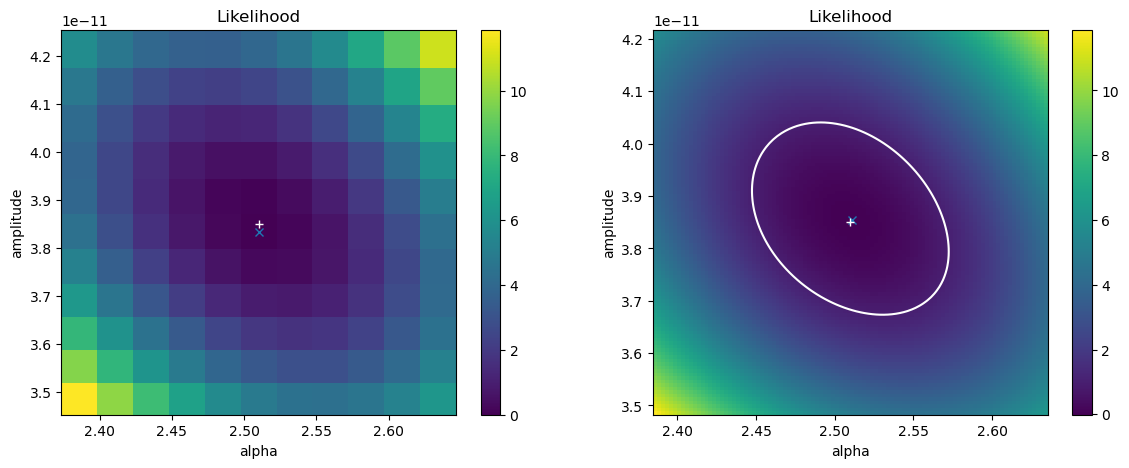

In [12]:
CSs, CS_Ns  = [] , []
for i in range(len(parameter_names)):
    CS, fig  = plot_surface(results[i], parameter_names[i][0], 
             parameter_names[i][1], source = source,plot_orig=1)
    fig.savefig(f"../{c['folder']}/plots/3_surface_{i}.pdf")
    CSs.append(CS)
    
    CS_N = plot_surface(results_N[i], parameter_names[i][0], 
             parameter_names[i][1], source = source,plot_orig=1)
    
    CS_Ns.append(CS_N)

In [ ]:
fig,axs = plt.subplots(2,2)
axs = [axs[1][0], axs[1][1], axs[0][0]]
for i, p in enumerate(parameter_names):
    ax = axs[i]
    dat = CSs[i].allsegs[0][0]
    ax.plot(
        dat[:, 0],
        dat[:, 1],
        color=awo[0],
    )
    
    dat = CSs[i].allsegs[0][0]
    ax.plot(
        dat[:, 0],
        dat[:, 1],
        color=aw[0],
    )
    
    ax.set_ylabel(p[0])
    ax.set_xlabel(p[1])
    p1 = dataset_asimov.models.parameters[p[0]]
    p2 = dataset_asimov.models.parameters[p[1]]
    ax.errorbar(p2.value, p1.value,  xerr = p2.error, 
               yerr = p1.error, color = awo[0])
    p1 = dataset_asimov_N.models.parameters[p[0]]
    p2 = dataset_asimov_N.models.parameters[p[1]]
    ax.errorbar(p2.value, p1.value,  xerr = p2.error, 
               yerr = p1.error, color = aw[0])
    
plt.tight_layout()

In [ ]:
ax = dataset_asimov.models[0].spectral_model.plot((0.1, 100)*u.TeV)
dataset_asimov.models[0].spectral_model.plot_error((0.1, 100)*u.TeV, ax = ax)


In [ ]:
results_N[0]